In [37]:
import numpy as np
import pandas as pd
import random

In [38]:
# Charger les données depuis le CSV
df = pd.read_csv('data/selected.csv')

# Nombre de villes
nb_villes = len(df)

In [39]:
# Fonction pour calculer la distance en kilomètres entre deux villes
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Rayon moyen de la Terre en kilomètres

    # Conversion des latitudes et longitudes de degrés en radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Différences entre les latitudes et longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Formule de Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance en kilomètres
    distance = R * c
    return distance

In [40]:
# Construire la matrice de distances à partir des coordonnées en utilisant la fonction haversine_distance
distances = np.zeros((nb_villes, nb_villes))
for i in range(nb_villes):
    for j in range(nb_villes):
        distances[i, j] = haversine_distance(df.iloc[i][' Latitude '], df.iloc[i][' Longitude '],
                                             df.iloc[j][' Latitude '], df.iloc[j][' Longitude '])


In [41]:
# Fonction pour calculer la distance totale d'un chemin
def total_distance(path, distances):
    total_dist = 0
    nb_villes = len(path)
    for i in range(nb_villes):
        total_dist += distances[path[i], path[(i + 1) % nb_villes]]
    return total_dist

In [42]:
# Fonction pour générer un voisin en échangeant deux villes dans le chemin
def generer_voisin(path):
    new_path = path.copy()
    idx1, idx2 = np.random.choice(len(path), 2, replace=False)
    new_path[idx1], new_path[idx2] = new_path[idx2], new_path[idx1]
    return new_path

In [43]:
# Algorithme du recuit simulé
def recuit_simulé(distances, premier_chemin, max_iterations, temperature_initiale, taux_refroidissement):
    sigma = premier_chemin
    meilleur_chemin = premier_chemin
    sigma_distance = total_distance(sigma, distances)
    meilleure_distance = sigma_distance
    temperature = temperature_initiale

    for i in range(max_iterations):
        voisin_chemin = generer_voisin(sigma)
        voisin_distance = total_distance(voisin_chemin, distances)
        delta_distance = voisin_distance - sigma_distance

        # Si le voisin est meilleur ou selon une certaine probabilité, acceptez le voisin
        if delta_distance < 0 or np.random.rand() < np.exp(-delta_distance / temperature):
            sigma = voisin_chemin
            sigma_distance = voisin_distance

            # Mettez à jour le meilleur chemin trouvé jusqu'à présent
            if sigma_distance < meilleure_distance:
                meilleur_chemin = sigma
                meilleure_distance = sigma_distance

        # Refroidissement
        temperature *= taux_refroidissement

    return meilleur_chemin, meilleure_distance

In [44]:
# Paramètres de l'algorithme
max_iterations = 10000  # Nombre maximum d'itérations
temperature_initiale = 1000.0  # Température initiale
taux_refroidissement = 0.995  # Taux de refroidissement

# Génération d'un chemin initial aléatoire
premier_chemin = np.random.permutation(nb_villes)

# Application de l'algorithme du recuit simulé
meilleur_chemin, meilleure_distance = recuit_simulé(distances, premier_chemin, max_iterations, temperature_initiale, taux_refroidissement)

# Afficher le meilleur chemin et sa distance
print("Meilleur chemin trouvé:", meilleur_chemin)
print("Distance minimale:", meilleure_distance)


Meilleur chemin trouvé: [19 30 12  0 21 38 35 23  7 24 33 31  6 18 25 34 17 26  1 27 13 37 15 16
  2 11  3 28 22 36 29  9 14  5 39 20 32 10  4  8]
Distance minimale: 5367.842816951419


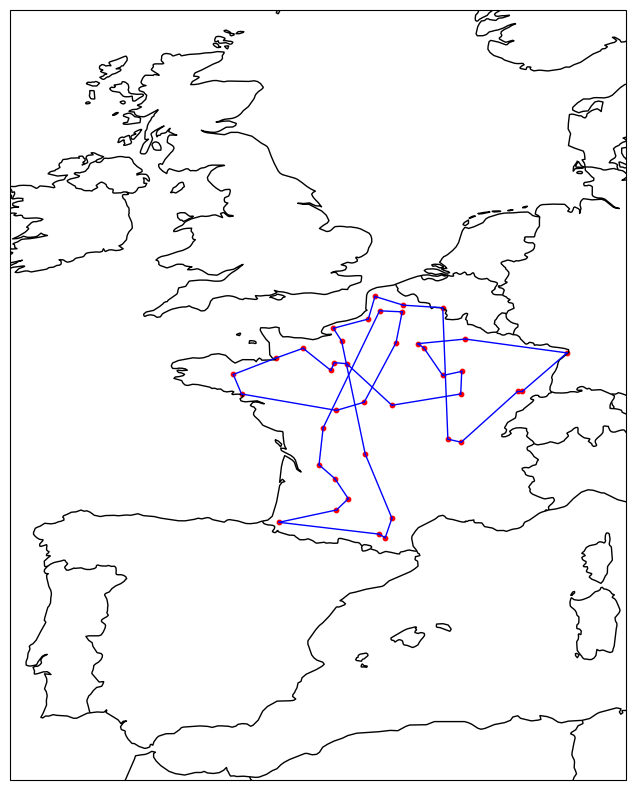

In [45]:
# Afficher le meilleur chemin sur la carte
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Créer une carte
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-10, 10, 35, 60], crs=ccrs.PlateCarree())


# Ajouter les frontières des pays
ax.add_feature(cfeature.BORDERS)


# Ajouter les côtes
ax.add_feature(cfeature.COASTLINE)


# Ajouter les villes
plt.scatter(df[' Longitude '], df[' Latitude '], color='red', s=10, transform=ccrs.PlateCarree())


# Ajouter le chemin indiqué par les indices des villes dans le meilleur chemin
for i in range(nb_villes):
    plt.plot([df.iloc[meilleur_chemin[i]][' Longitude '], df.iloc[meilleur_chemin[(i + 1) % nb_villes]][' Longitude ']],
             [df.iloc[meilleur_chemin[i]][' Latitude '], df.iloc[meilleur_chemin[(i + 1) % nb_villes]][' Latitude ']],
             color='blue', linewidth=1, transform=ccrs.PlateCarree())

plt.show()
